In [1]:
# 🧩 Cell 1 — Seadistus (teegid ja failiteed)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# >> Kohanda teed vastavalt oma arvutile <<
tarb_path = Path(r"C:\Users\User\Desktop\Electricity-Forecast-Git\Electricity-Consumption-Forecast\electricity_input_data\Tarb_aug24.xlsx")
temp_path = Path(r"C:\Users\User\Desktop\Electricity-Forecast-Git\Electricity-Consumption-Forecast\electricity_input_data\Temp_aug24.xlsx")

In [2]:
# 🧩 Cell 2 — Abifunktsioonid (veerunimed, arvuliseks, datetime)

def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Trim + tühikud -> alakriips + väiketähed (turvaline veerunimede ühtlustus)."""
    df.columns = (df.columns
                  .str.strip()
                  .str.replace(r"\s+", "_", regex=True)
                  .str.lower())
    return df

def ensure_numeric(s: pd.Series) -> pd.Series:
    """Teisenda veerg arvuliseks, arvestab ka tühikuid ja koma->punkt vahetust."""
    if pd.api.types.is_numeric_dtype(s):
        return pd.to_numeric(s, errors="coerce")
    s2 = (s.astype(str)
            .str.replace("\u00A0", "", regex=False)  # non-breaking space
            .str.replace(" ", "", regex=False)
            .str.replace(",", ".", regex=False))
    return pd.to_numeric(s2, errors="coerce")

def combine_date_time(df: pd.DataFrame) -> pd.DataFrame:
    """
    Loo ühtne 'datetime' veerg.
    - 'kpv' on juba datetime (Exceli date), 'aeg' on time või 'HH:MM(:SS)' string.
    """
    if "kpv" not in df.columns or "aeg" not in df.columns:
        raise ValueError("Vajalikud veerud 'kpv' ja 'aeg' puuduvad.")
    if not pd.api.types.is_datetime64_any_dtype(df["kpv"]):
        raise TypeError("Veerg 'kpv' peab olema datetime64 dtype (Exceli kuupäev).")

    # teisenda 'aeg' pandas Timedelta-ks
    time_str = df["aeg"].astype(str).str.strip()          # nt '01:00:00'
    time_delta = pd.to_timedelta(time_str, errors="coerce")

    out = df.copy()
    out["datetime"] = out["kpv"].dt.normalize() + time_delta
    out = out.dropna(subset=["datetime"]).copy()          # eemalda vigased read
    return out

In [4]:
# 🧩 Cell 3 — Impordi mõlemad failid ja eeltöötlus

# Loe Excelid
tarb = pd.read_excel(tarb_path, engine="openpyxl")
temp = pd.read_excel(temp_path, engine="openpyxl")

# Ühtlusta veerunimed
tarb = clean_columns(tarb)   # eeldus: kpv, aeg, tarbimine
temp = clean_columns(temp)   # eeldus: kpv, aeg, temperatuur (või 'temp')

# Kui temperatuur on veerus 'temp', nimeta ümber
if "temp" in temp.columns and "temperatuur" not in temp.columns:
    temp = temp.rename(columns={"temp": "temperatuur"})

# Loo ühtne ajatempel
tarb = combine_date_time(tarb)
temp = combine_date_time(temp)

# Teisenda mõõdikud arvuliseks
tarb["tarbimine"]   = ensure_numeric(tarb["sum_el_hourly_value"])
temp["temperatuur"] = ensure_numeric(temp["hour_temp_value"])

# Eemalda read, kus mõõdik puudub
tarb = tarb.dropna(subset=["tarbimine"]).copy()
temp = temp.dropna(subset=["temperatuur"]).copy()

print("Tarb vahemik:", tarb["datetime"].min(), "→", tarb["datetime"].max(), "| read:", len(tarb))
print("Temp vahemik:", temp["datetime"].min(), "→", temp["datetime"].max(), "| read:", len(temp))

Tarb vahemik: 2024-09-01 00:00:00 → 2025-08-31 23:00:00 | read: 8756
Temp vahemik: 2024-09-01 01:00:00 → 2025-08-31 00:00:00 | read: 8566


In [5]:
# 🧩 Cell 5 — Tunnipõhine koond (tarbimine=sum, temperatuur=mean)

tarb_h = (
    tarb.resample("H", on="datetime")["tarbimine"]
        .sum()
        .reset_index()
)

temp_h = (
    temp.resample("H", on="datetime")["temperatuur"]
        .mean()
        .reset_index()
)

tarb_h.head(), temp_h.head()

C:\Users\User\AppData\Local\Temp\ipykernel_49468\499908265.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  tarb.resample("H", on="datetime")["tarbimine"]
C:\Users\User\AppData\Local\Temp\ipykernel_49468\499908265.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  temp.resample("H", on="datetime")["temperatuur"]


(             datetime  tarbimine
 0 2024-09-01 00:00:00      619.5
 1 2024-09-01 01:00:00      585.4
 2 2024-09-01 02:00:00      563.0
 3 2024-09-01 03:00:00      554.0
 4 2024-09-01 04:00:00      555.5,
              datetime  temperatuur
 0 2024-09-01 01:00:00    12.346786
 1 2024-09-01 02:00:00    12.546382
 2 2024-09-01 03:00:00    12.196983
 3 2024-09-01 04:00:00    11.887848
 4 2024-09-01 05:00:00    11.732937)

In [26]:
# 🧩 Cell 6 — Kuupõhised kokkuvõtted + katvus (coverage)

def month_start(ts: pd.Series) -> pd.Series:
    """Kuu alguse Timestamp (MS)."""
    return ts.dt.to_period("M").dt.to_timestamp()

# Lisa kuu veerg
tarb_h["kuu"] = month_start(tarb_h["datetime"])
temp_h["kuu"] = month_start(temp_h["datetime"])

# Kuu koond: tarbimine (sum) + mitu tunnikirjet oli (coverage jaoks)
tarb_m = (
    tarb_h.groupby("kuu", as_index=False)
          .agg(kuu_sum_tarb=("tarbimine", "sum"),
               hours_tarb_present=("tarbimine", "count"))
)

# Kuu koond: temperatuur (mean) + mitu tunnikirjet oli #(coverage jaoks)
temp_m = (
    temp_h.groupby("kuu", as_index=False)
          .agg(kuu_keskmine_temp=("temperatuur", "mean"),
               hours_temp_present=("temperatuur", "count"))
)

# Arvuta kuu kogutundide arv (min..max tunnivahemiku põhjal)
all_min = min(tarb_h["datetime"].min(), temp_h["datetime"].min())
all_max = max(tarb_h["datetime"].max(), temp_h["datetime"].max())
all_hours = pd.DataFrame({"datetime": pd.date_range(all_min, all_max, freq="H")})
all_hours["kuu"] = month_start(all_hours["datetime"])
hours_total = (all_hours.groupby("kuu", as_index=False)["datetime"]
                        .count()
                        .rename(columns={"datetime":"hours_total"}))

# Lõplik kuutabel
monthly = (tarb_m.merge(temp_m, on="kuu", how="outer")
                 .merge(hours_total, on="kuu", how="left")
                 .sort_values("kuu")
                 .reset_index(drop=True))

# Coverage suhtarvud
monthly["tarb_coverage"] = (monthly["hours_tarb_present"] / monthly["hours_total"]).round(3)
monthly["temp_coverage"] = (monthly["hours_temp_present"] / monthly["hours_total"]).round(3)

# Esituslik ümardus
monthly["kuu_keskmine_temp"] = monthly["kuu_keskmine_temp"].round(2)
monthly["kuu_sum_tarb"] = monthly["kuu_sum_tarb"].round(0)
monthly

C:\Users\User\AppData\Local\Temp\ipykernel_49468\667052859.py:28: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  all_hours = pd.DataFrame({"datetime": pd.date_range(all_min, all_max, freq="H")})


,kuu,kuu_sum_tarb,hours_tarb_present,kuu_keskmine_temp,hours_temp_present,hours_total,tarb_coverage,temp_coverage
0,2024-09-01,531317.0,720,16.16,701,720,1.0,0.974
1,2024-10-01,654792.0,744,8.09,722,744,1.0,0.970
2,2024-11-01,721380.0,720,3.49,709,720,1.0,0.985
3,2024-12-01,777516.0,744,0.31,734,744,1.0,0.987
4,2025-01-01,784294.0,744,0.19,736,744,1.0,0.989
5,2025-02-01,723527.0,672,-3.73,658,672,1.0,0.979
6,2025-03-01,677993.0,744,3.00,738,744,1.0,0.992
7,2025-04-01,613459.0,720,6.76,707,720,1.0,0.982
8,2025-05-01,600480.0,744,9.85,732,744,1.0,0.984
9,2025-06-01,571327.0,720,14.47,711,720,1.0,0.988


In [15]:
# 🧩 Cell 7 — (Valikuline) Filtreeri soovitud perioodile

# Näide: 2024-09-01 kuni 2025-08-31 (kaasav)
start = pd.Timestamp("2024-10-01")
end   = pd.Timestamp("2025-08-31 23:59:59")

monthly_sel = monthly[(monthly["kuu"] >= start.normalize()) & (monthly["kuu"] <= end.normalize())].copy()
monthly_sel

,kuu,kuu_sum_tarb,hours_tarb_present,kuu_keskmine_temp,hours_temp_present,hours_total,tarb_coverage,temp_coverage
1,2024-10-01,654792.0,744,8.09,722,744,1.0,0.970
2,2024-11-01,721380.0,720,3.49,709,720,1.0,0.985
3,2024-12-01,777516.0,744,0.31,734,744,1.0,0.987
4,2025-01-01,784294.0,744,0.19,736,744,1.0,0.989
5,2025-02-01,723527.0,672,-3.73,658,672,1.0,0.979
6,2025-03-01,677993.0,744,3.00,738,744,1.0,0.992
7,2025-04-01,613459.0,720,6.76,707,720,1.0,0.982
8,2025-05-01,600480.0,744,9.85,732,744,1.0,0.984
9,2025-06-01,571327.0,720,14.47,711,720,1.0,0.988
10,2025-07-01,582434.0,744,19.99,709,744,1.0,0.953


Pearson (kuu tase):  -0.860
Spearman (kuu tase): -0.909


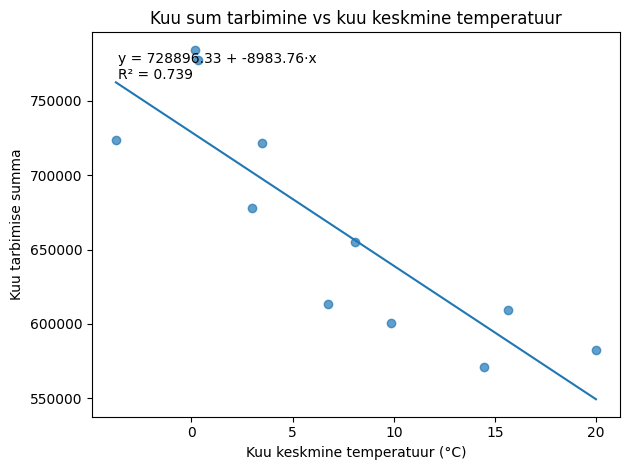

In [16]:
# 🧩 Cell 8 — Korrelatsioon (kuu tase) + hajuvusgraafik regressioonijoonega 

#installi scipy, kui pole veel tehtud
#pip install scipy


# vali tabel, millega töötad
base_m = monthly_sel if len(monthly_sel) >= 2 else monthly
corr_df = base_m.dropna(subset=["kuu_sum_tarb", "kuu_keskmine_temp"]).copy()

# Pearson ja Spearman
pearson = corr_df["kuu_sum_tarb"].corr(corr_df["kuu_keskmine_temp"], method="pearson")
spearman = corr_df["kuu_sum_tarb"].corr(corr_df["kuu_keskmine_temp"], method="spearman")
print(f"Pearson (kuu tase):  {pearson:.3f}")
print(f"Spearman (kuu tase): {spearman:.3f}")

# Hajuvus + regressioonijoon + võrrand + R^2
x = corr_df["kuu_keskmine_temp"].to_numpy()
y = corr_df["kuu_sum_tarb"].to_numpy()
mask = np.isfinite(x) & np.isfinite(y)
x, y = x[mask], y[mask]

if x.size >= 2 and y.size >= 2:
    b1, b0 = np.polyfit(x, y, 1)  # y ≈ b0 + b1*x
    y_hat = b0 + b1*x
    r2 = 1 - ((y - y_hat)**2).sum() / ((y - y.mean())**2).sum()

    plt.scatter(x, y, alpha=0.7)
    xx = np.linspace(x.min(), x.max(), 100)
    plt.plot(xx, b0 + b1*xx)
    plt.title("Kuu sum tarbimine vs kuu keskmine temperatuur")
    plt.xlabel("Kuu keskmine temperatuur (°C)")
    plt.ylabel("Kuu tarbimise summa")

    ax = plt.gca()
    ax.text(0.05, 0.95, f"y = {b0:.2f} + {b1:.2f}·x\nR² = {r2:.3f}",
            transform=ax.transAxes, va="top")
    plt.tight_layout()
    plt.show()
else:
    print("Graafiku jaoks on vaja vähemalt 2 kuud andmeid.")

In [19]:
from pathlib import Path

# Loo kaust (kui seda veel ei ole)
outdir = Path("output")
outdir.mkdir(parents=True, exist_ok=True)

# Salvesta faili
outfile = outdir / "kuu_vahetabel.xlsx"
monthly.to_excel(outfile, index=False)

print(f"Salvestatud: {outfile.resolve()}")

Salvestatud: C:\Users\User\Desktop\Electricity-Forecast-Git\Electricity-Consumption-Forecast\output\kuu_vahetabel.xlsx


In [23]:
# 🧩 Cell 1 — Õpeta lihtne mudel (ilma lisateekideta)

# import numpy as np
import pandas as pd

# 1) vali treeninguks ainult need kuud, kus mõlemad väärtused olemas
train = monthly.dropna(subset=["kuu_sum_tarb", "kuu_keskmine_temp", "hours_total"]).copy()

# 2) normaliseeri: kuutarbimine -> tarbimine per tund (et kuu pikkus ei segaks)
train["y_hour"] = train["kuu_sum_tarb"] / train["hours_total"]

# 3) sobita sirgjoon: y_hour ≈ a + b*T
b, a = np.polyfit(train["kuu_keskmine_temp"].to_numpy(), train["y_hour"].to_numpy(), 1)

print(f"Mudel: y_hour ≈ {a:.3f} + {b:.3f} * T")

Mudel: y_hour ≈ 1011.875 + -14.656 * T


In [24]:
# 🧩 Cell 2 — Funktsioon: sisend = T (°C) + kuu → väljund = kuu tarbimine

import pandas as pd
import numpy as np

# eeldan, et a ja b on treenitud varem:
# b, a = np.polyfit(train["kuu_keskmine_temp"], train["y_hour"], 1)

def prognoos_kuu_tarbimine(T_c: float, any_date_in_month) -> float:
    """
    Ennustab kuu tarbimise (sama ühik nagu 'kuu_sum_tarb').
    T_c = kuu keskmise temperatuuri prognoos (°C)
    any_date_in_month = suvaline kuupäev sellest kuust (nt '2025-01-15' või Timestamp)
    """
    d = pd.to_datetime(any_date_in_month)

    # Kuu algus ja järgmise kuu algus
    start = d.to_period("M").to_timestamp()     # kuu algus (start_time)
    next_start = start + pd.offsets.MonthBegin(1)  # järgmise kuu algus

    # Kuutundide arv
    hours_total = int((next_start - start) / pd.Timedelta(hours=1))

    # Ennustatud tarbimine tunnis (lõikame negatiivse nulli peale)
    y_hour_hat = max(0.0, a + b * T_c)

    # Kuu tarbimine
    return y_hour_hat * hours_total

In [25]:
# Kiirtest 1

tarb_10c_jan25 = prognoos_kuu_tarbimine(10, "2025-01-15")
print(f"T=10°C, 2025-01 → prognoos: {tarb_10c_jan25:,.0f}")

T=10°C, 2025-01 → prognoos: 643,798
